## High frequency motion Eulerian and Lagrangian energy

### Notation : 

$\tilde{u}$, $\tilde{v}$ : zonal and meridional band pass filtered total velocity fields

$[.]_t$ : Eulerian temporal average


$< . >_b$ : bin average

$< . >_{t,b}$ : average over time and bin



In [1]:
import xarray as xr
import numpy as np

from scipy import stats, fft

import matplotlib.pyplot as plt

import os
from glob import glob
import threading

import dask.dataframe as dd
from dask import delayed
import pandas as pd
import scipy.optimize
#import mitequinox.sigp as sp

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

from inspect import signature
import scipy

In [2]:
root_path = '/Users/zcaspar/codes/mit4320/'

ds_dl1 = xr.merge([xr.open_dataset(root_path+'energy_SSU_hf_binned_dl1.0.nc'),
                   xr.open_dataset(root_path+'energy_SSV_hf_binned_dl1.0.nc'),
                   xr.open_dataset(root_path+'energy_hf_binned_dl1.0.nc')])

ds_dl2 = xr.merge([xr.open_dataset(root_path+'energy_SSU_hf_binned_dl2.0.nc'),
                   xr.open_dataset(root_path+'energy_SSV_hf_binned_dl2.0.nc')])

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
def plot_maps(ds,colmap='RdBu_r',vlim=(-0.01,0.01),axes=111,**kwargs):
    crs = ccrs.Robinson()
    #fig = plt.figure(figsize=figsize)
    cbar_kwargs = {'fraction':0.02}
    cbar_kwargs.update(**kwargs)
    ax = fig.add_subplot(axes,projection=crs)
    ds.plot(vmax=vlim[1],vmin=vlim[0],y='lat_bin',ax=ax,
            transform=ccrs.PlateCarree(),cmap=colmap,label=False,#**kwargs,
            cbar_kwargs=cbar_kwargs) #{'fraction':0.02,'label':'energy'}
    ax.gridlines(draw_labels=True)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)
    return fig,ax

In [4]:
ds_hf = ds_dl1.where(ds_dl1.waterdepth>500)
ds_hf_dl2 = ds_dl2.where(ds_dl2.waterdepth>500)
#ds_low_var = ds_low_var_dl1.where(ds_low_var_dl1.waterdepth>500)

In [5]:
ds_hf

<xarray.Dataset>
Dimensions:       (lon_bin: 359, lat_bin: 119)
Coordinates:
  * lon_bin       (lon_bin) float64 -179.5 -178.5 -177.5 ... 176.5 177.5 178.5
  * lat_bin       (lat_bin) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
Data variables:
    E_count       (lon_bin, lat_bin) float64 288.0 276.0 276.0 ... 252.0 251.0
    E_energy_SSU  (lon_bin, lat_bin) float64 0.001918 0.001416 ... 0.03045
    L_energy_SSU  (lon_bin, lat_bin) float64 0.001947 0.0008158 ... 0.03117
    waterdepth    (lon_bin, lat_bin) float64 4.347e+03 4.968e+03 ... 3.745e+03
    L_count       (lon_bin, lat_bin) float64 217.0 215.0 ... 6.38e+03 2.066e+03
    E_energy_SSV  (lon_bin, lat_bin) float64 0.001605 0.001155 ... 0.02912
    L_energy_SSV  (lon_bin, lat_bin) float64 0.001742 0.0008039 ... 0.02922
    E_energy      (lon_bin, lat_bin) float64 0.003523 0.002571 ... 0.05957
    L_energy      (lon_bin, lat_bin) float64 0.003689 0.00162 ... 0.02651 0.0604

Text(0.5, 1.0, 'Lagrangian - Eulerian low frequency energy difference, $<\\tilde u_L^2>_{t,b}-<[\\tilde u_E^2]_t>_b$')

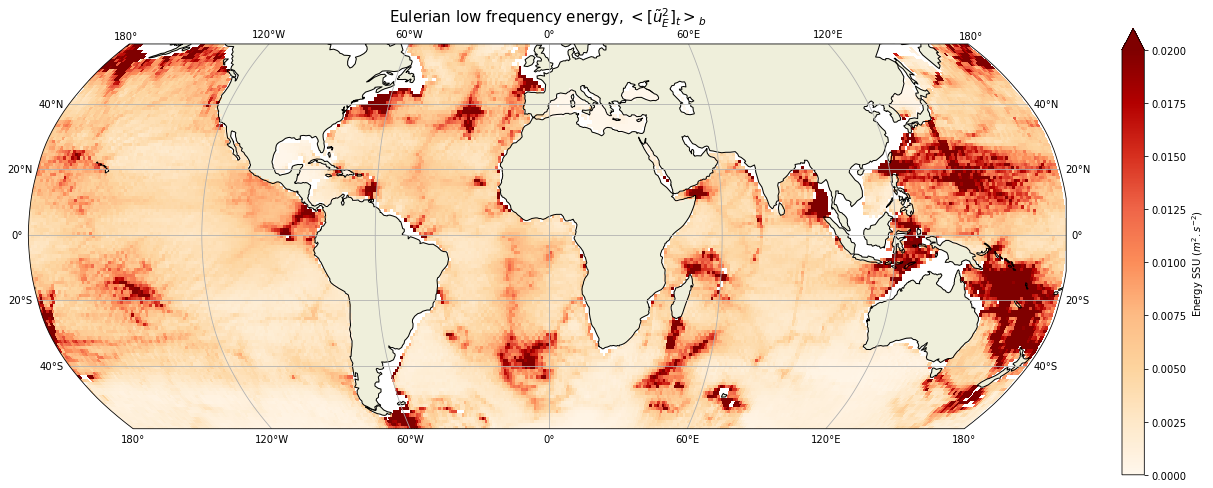

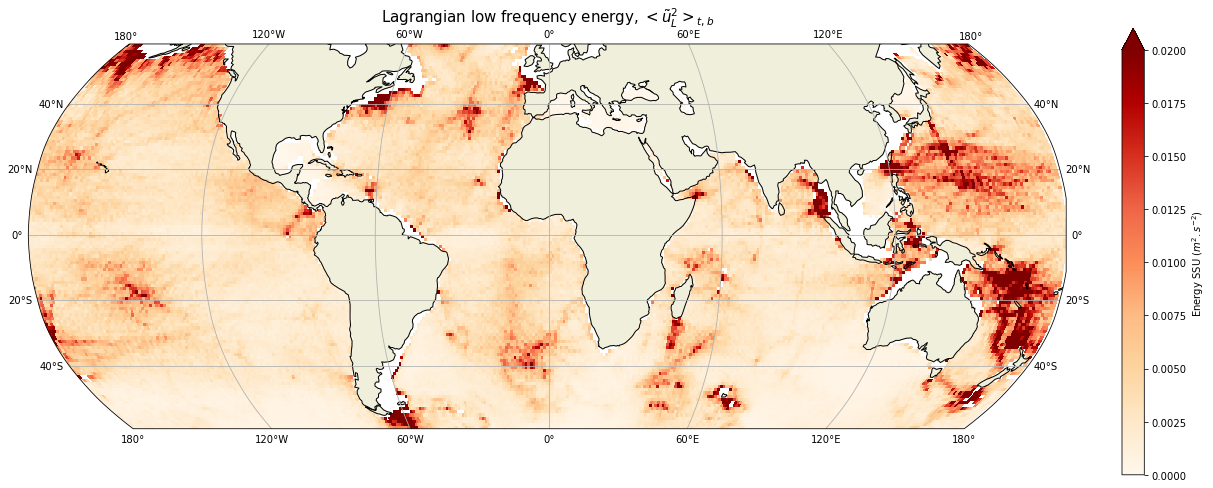

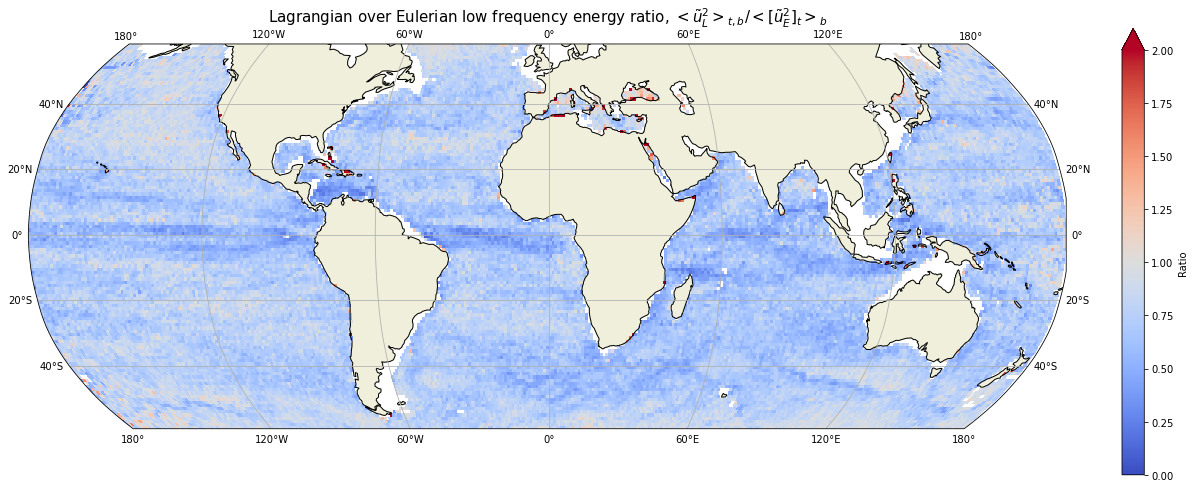

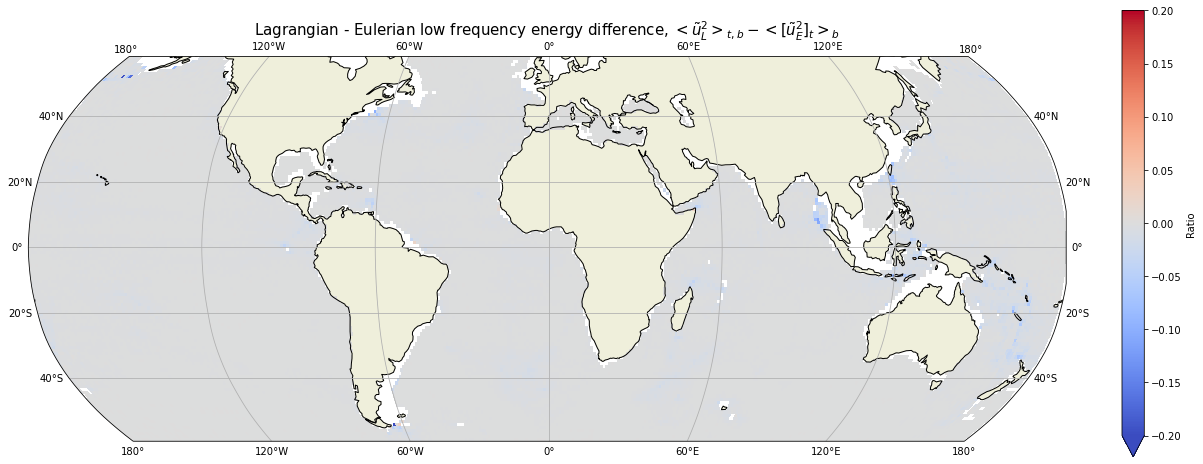

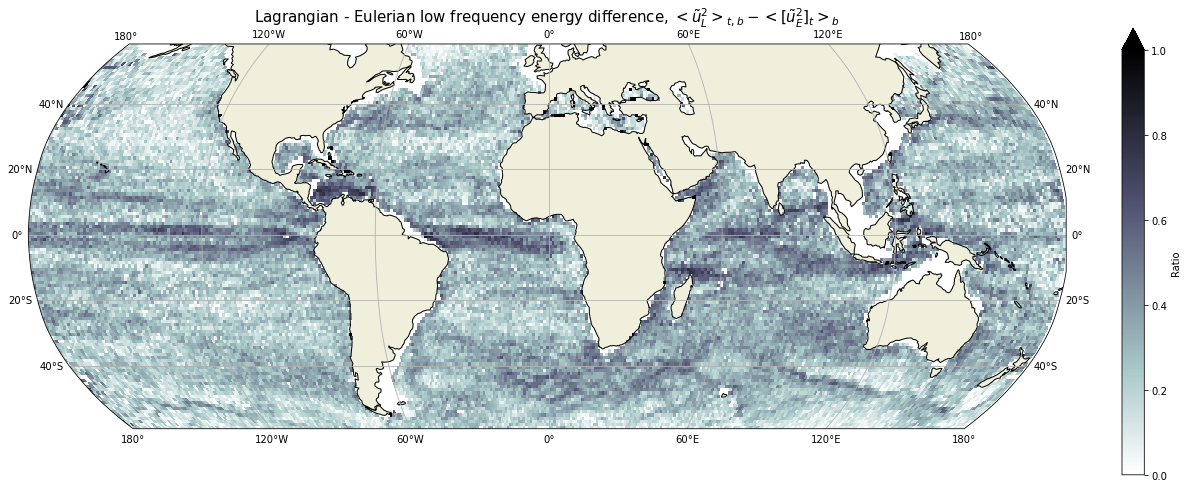

In [32]:
figsize = (20,20)
cmap = 'OrRd'
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_hf.E_energy_SSU,colmap=cmap,vlim=(0,0.02),**{'label':r'Energy SSU ($m^2.s^{-2}$)'})
ax.set_title(r'Eulerian low frequency energy, $<[\tilde u_E^2]_t>_b$',size=15)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_hf.L_energy_SSU,colmap=cmap,vlim=(0,0.02),**{'label':r'Energy SSU ($m^2.s^{-2}$)'})
ax.set_title(r'Lagrangian low frequency energy, $<\tilde u_L^2>_{t,b}$',size=15)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_hf.L_energy_SSU/ds_hf.E_energy_SSU,colmap='coolwarm',vlim=(0,2),**{'label':'Ratio'})
ax.set_title(r'Lagrangian over Eulerian low frequency energy ratio, $<\tilde u_L^2>_{t,b}/<[\tilde u_E^2]_t>_b$'
             ,size=15)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_hf.L_energy_SSU-ds_hf.E_energy_SSU,colmap='coolwarm',vlim=(-0.2,0.2),**{'label':'Ratio'})
ax.set_title(r'Lagrangian - Eulerian low frequency energy difference, $<\tilde u_L^2>_{t,b}-<[\tilde u_E^2]_t>_b$'
             ,size=15)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.abs((ds_hf.L_energy_SSU-ds_hf.E_energy_SSU)/ds_hf.E_energy_SSU),colmap='bone_r',vlim=(0,1),**{'label':'Ratio'})
ax.set_title(r'Lagrangian - Eulerian low frequency energy difference, $<\tilde u_L^2>_{t,b}-<[\tilde u_E^2]_t>_b$'
             ,size=15)

Text(0.5, 1.0, 'Number of drifters per bin')

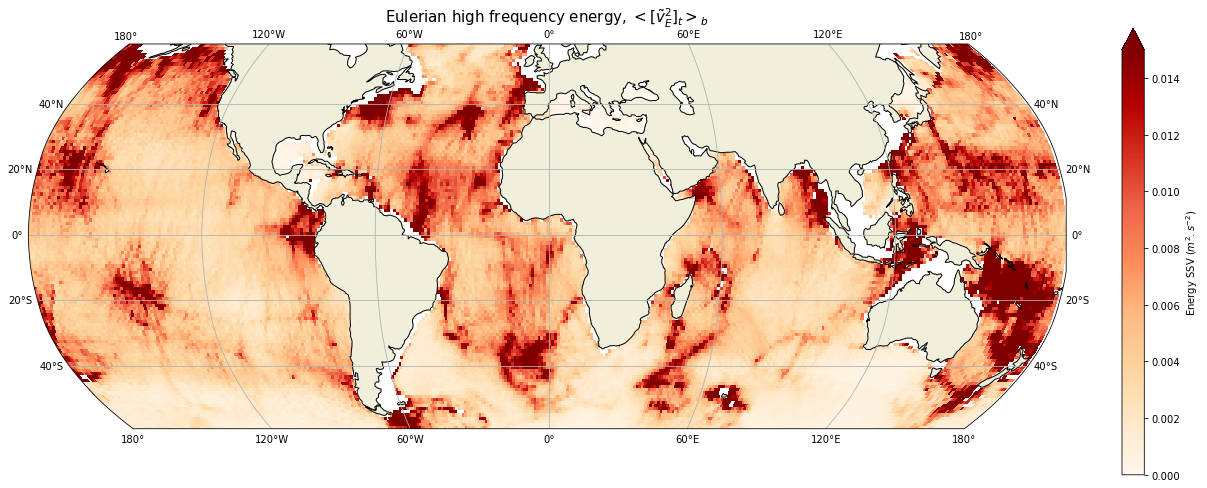

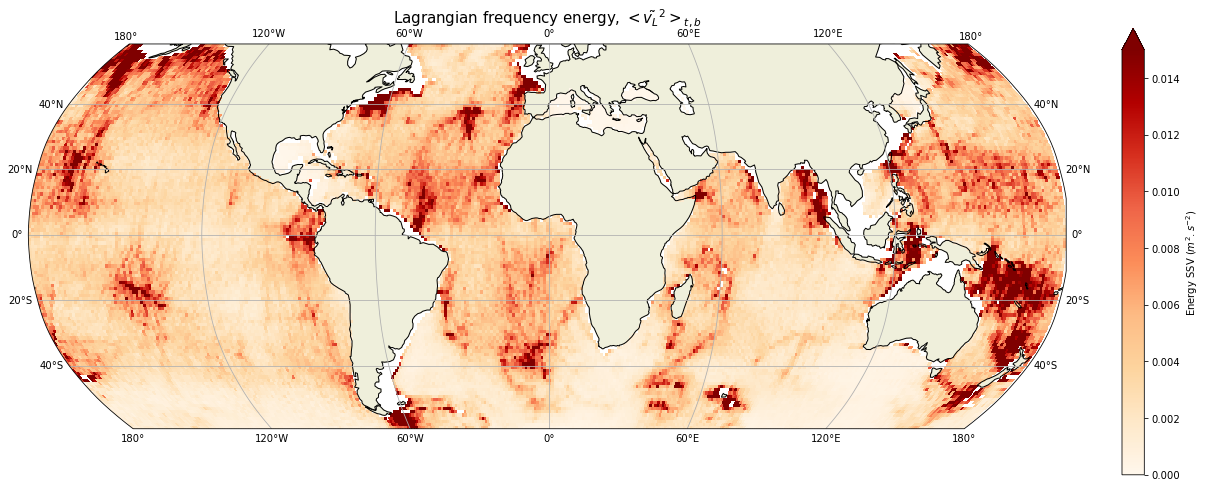

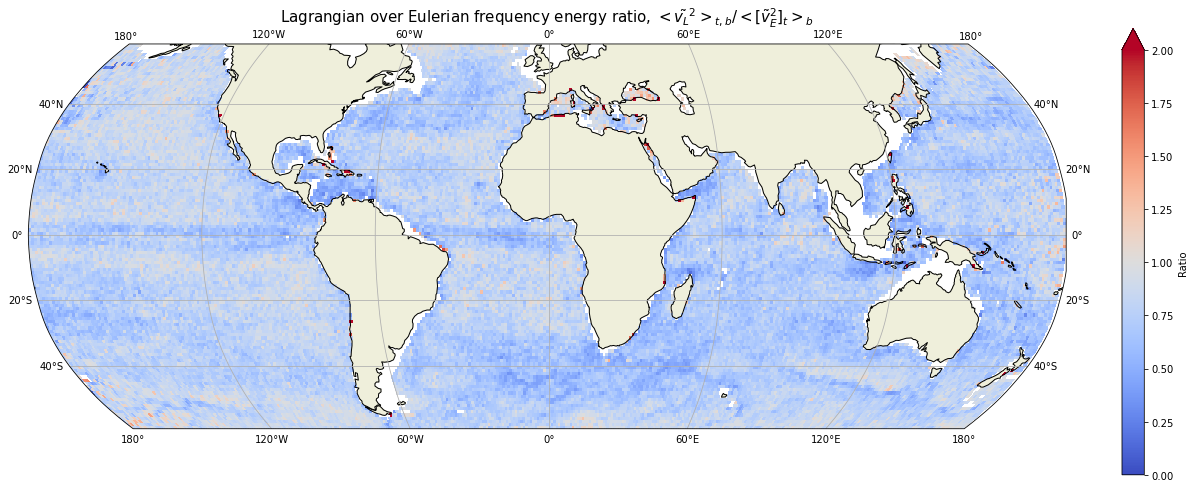

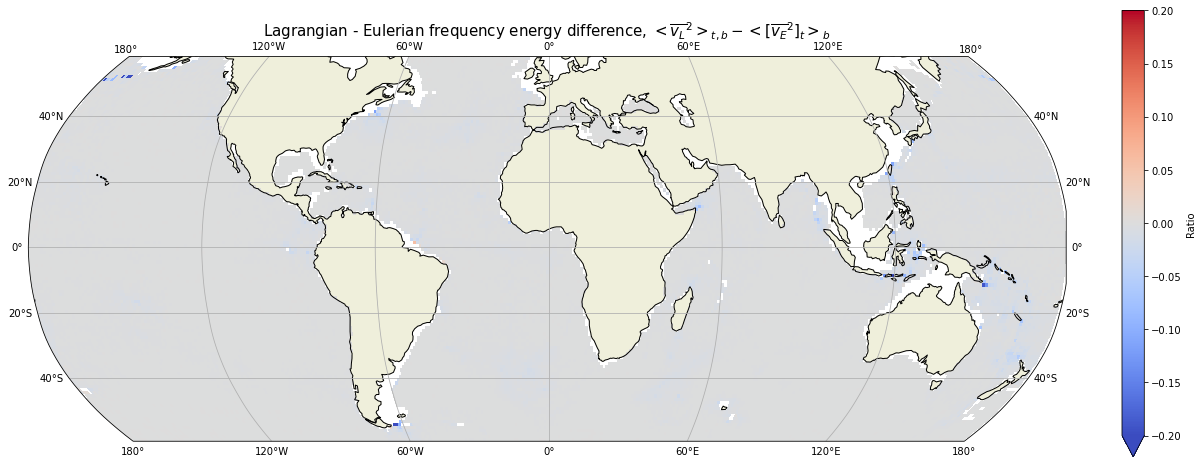

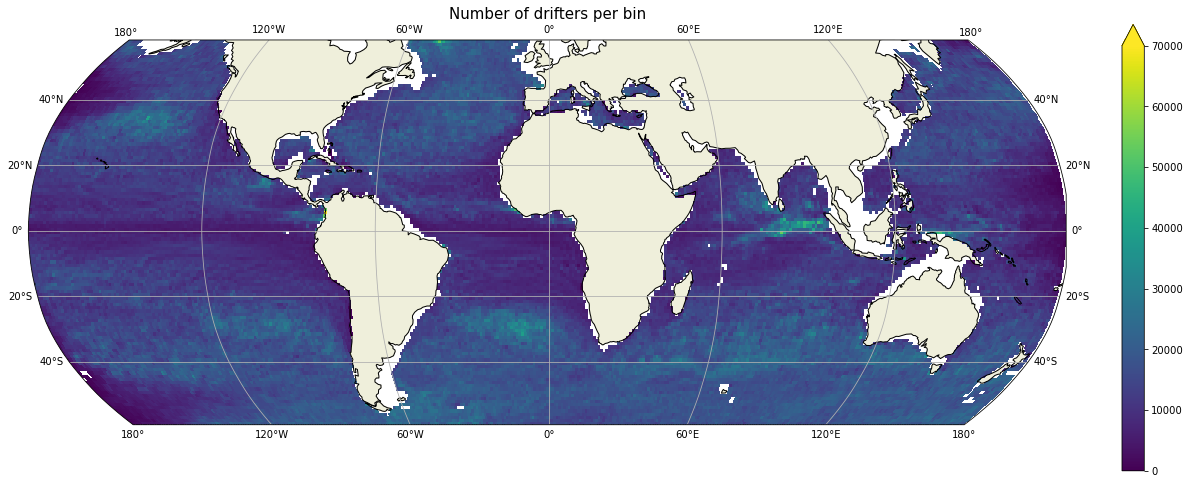

In [34]:
figsize = (20,20)
cmap = 'OrRd'
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_hf.E_energy_SSV,colmap=cmap,vlim=(0,0.015),**{'label':r'Energy SSV ($m^2.s^{-2}$)'})
ax.set_title(r'Eulerian high frequency energy, $<[\tilde{v}_E^2]_t>_b$',size=15)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_hf.L_energy_SSV,colmap=cmap,vlim=(0,0.015),**{'label':r'Energy SSV ($m^2.s^{-2}$)'})
ax.set_title(r'Lagrangian frequency energy, $<\tilde{v_L}^2>_{t,b}$',size=15)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_hf.L_energy_SSV/ds_hf.E_energy_SSV,colmap='coolwarm',vlim=(0.,2),**{'label':'Ratio'})
ax.set_title(r'Lagrangian over Eulerian frequency energy ratio, $<\tilde{v_L}^2>_{t,b}/<[\tilde{v}_E^2]_t>_b$'
             ,size=15)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_hf.L_energy_SSV-ds_hf.E_energy_SSV,colmap='coolwarm',vlim=(-0.2,0.2),**{'label':'Ratio'})
ax.set_title(r'Lagrangian - Eulerian frequency energy difference, $<\overline{v_L}^2>_{t,b}-<[\overline{v_E}^2]_t>_b$'
             ,size=15)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_hf.L_count,colmap='viridis',vlim=(0.,70000),**{'label': ''})
ax.set_title(r'Number of drifters per bin',size=15)

Text(0.5, 1.0, '$<\\tilde{u_L}^2+\\tilde{v_L}^2>_{t,b}-<[\\tilde{u_E}^2+\\tilde{v_E}^2]_t>_b$')

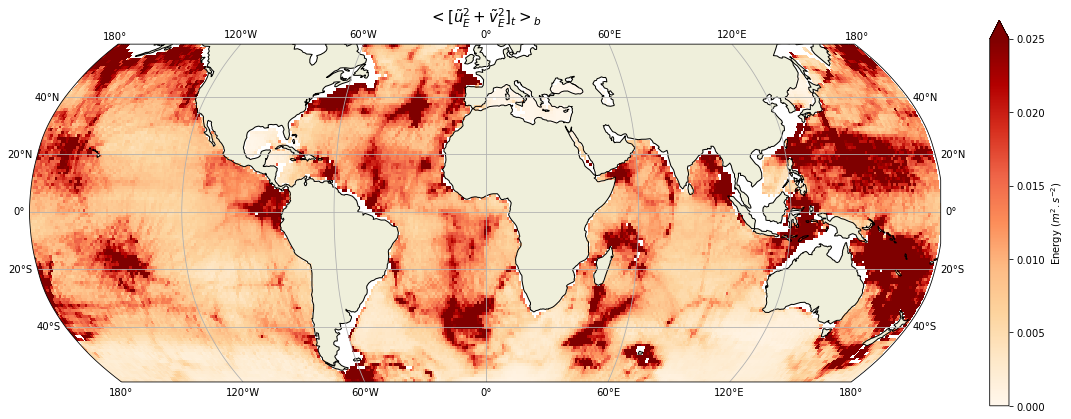

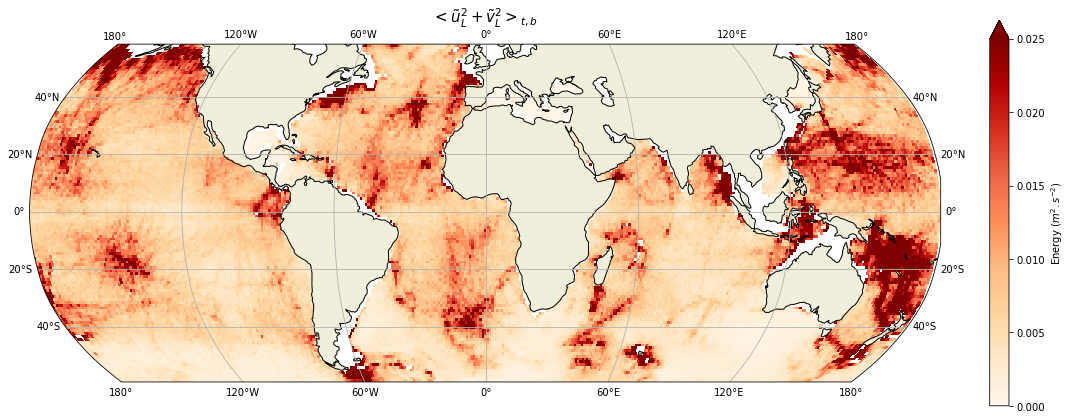

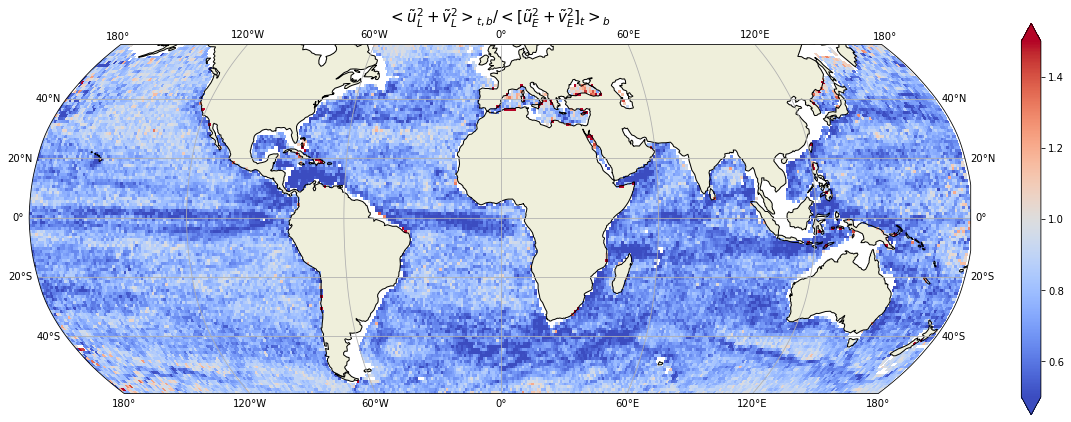

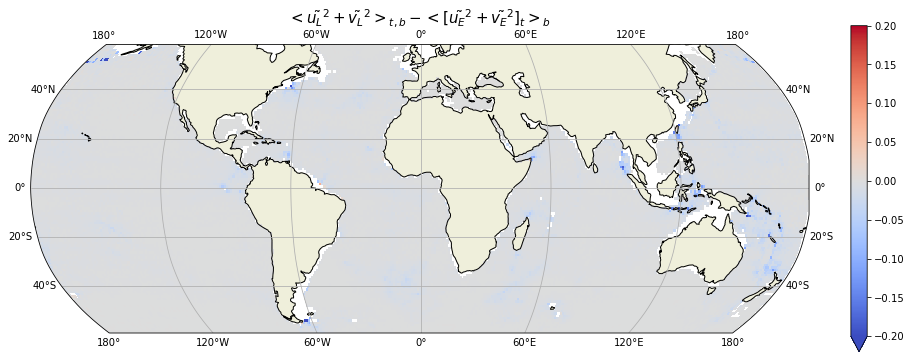

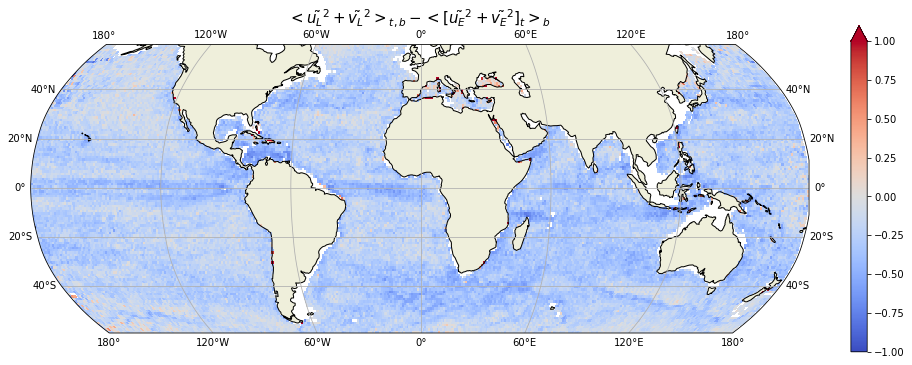

In [79]:
figsize = (15,6)
cmap = 'OrRd'
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_hf.E_energy_hf,colmap=cmap,vlim=(0,0.025),**{'label':r'Energy ($m^2.s^{-2}$)'})
ax.set_title(r'$<[\tilde{u}_E^2+\tilde{v}_E^2]_t>_b$',size=15)
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/E_energy_hf.png',bbox_inches='tight')

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_hf.L_energy_hf,colmap=cmap,vlim=(0,0.025),**{'label':r'Energy ($m^2.s^{-2}$)'})
ax.set_title(r'$<\tilde{u}_L^2+\tilde{v}_L^2>_{t,b}$',size=15)
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_energy_hf.png',bbox_inches='tight')


fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_hf.L_energy_hf/ds_hf.E_energy_hf,colmap='coolwarm',vlim=(0.5,1.5),**{'label':''})
ax.set_title(r'$<\tilde{u}_L^2+\tilde{v}_L^2>_{t,b}/<[\tilde{u}_E^2+\tilde{v}_E^2]_t>_b$'
             ,size=15)
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/LE_energy_hf.png',bbox_inches='tight')

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_hf.L_energy_hf-ds_hf.E_energy_hf,colmap='coolwarm',vlim=(-0.2,0.2),**{'label':''})
ax.set_title(r'$<\tilde{u_L}^2+\tilde{v_L}^2>_{t,b}-<[\tilde{u_E}^2+\tilde{v_E}^2]_t>_b$'
             ,size=15)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((ds_hf.L_energy_hf-ds_hf.E_energy_hf)/ds_hf.E_energy_hf,colmap='coolwarm',vlim=(-1,1),**{'label':''})
ax.set_title(r'$<\tilde{u_L}^2+\tilde{v_L}^2>_{t,b}-<[\tilde{u_E}^2+\tilde{v_E}^2]_t>_b$'
             ,size=15)

Text(0.5, 1.0, 'Lagrangian over Eulerian low frequency energy ratio, $<\\tilde u_L^2>_{t,b}/<[\\tilde u_E^2]_t>_b$')

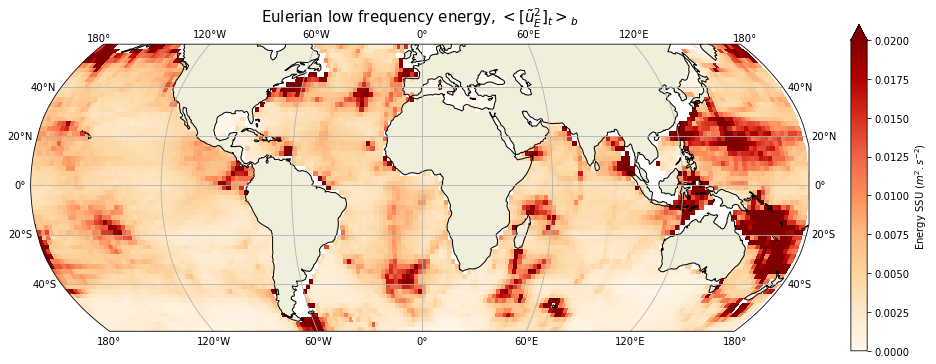

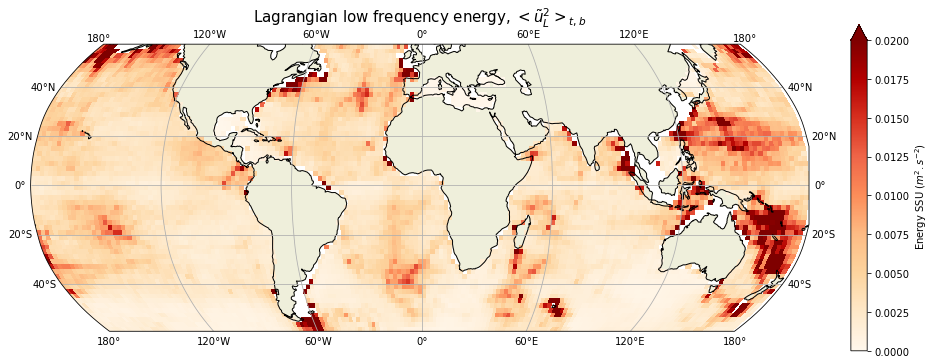

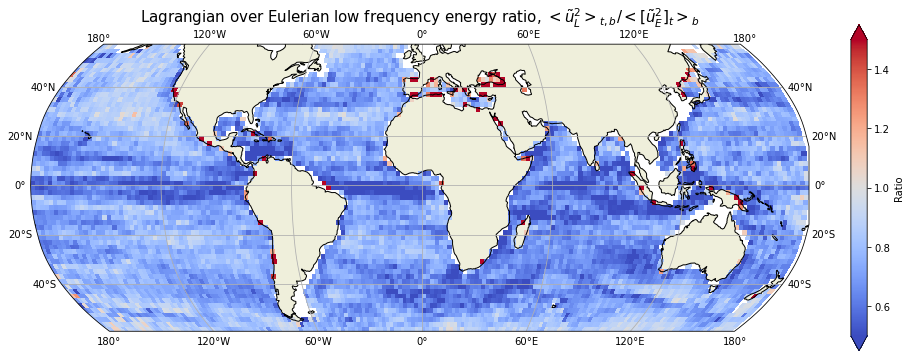

In [46]:
cmap = 'OrRd'
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_hf_dl2.E_energy_SSU,colmap=cmap,vlim=(0,0.02),**{'label':r'Energy SSU ($m^2.s^{-2}$)'})
ax.set_title(r'Eulerian low frequency energy, $<[\tilde u_E^2]_t>_b$',size=15)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_hf_dl2.L_energy_SSU,colmap=cmap,vlim=(0,0.02),**{'label':r'Energy SSU ($m^2.s^{-2}$)'})
ax.set_title(r'Lagrangian low frequency energy, $<\tilde u_L^2>_{t,b}$',size=15)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_hf_dl2.L_energy_SSU/ds_hf_dl2.E_energy_SSU,colmap='coolwarm',vlim=(0.5,1.5),**{'label':'Ratio'})
ax.set_title(r'Lagrangian over Eulerian low frequency energy ratio, $<\tilde u_L^2>_{t,b}/<[\tilde u_E^2]_t>_b$'
             ,size=15)

Text(0.5, 1.0, 'Lagrangian over Eulerian low frequency energy ratio, $<\\tilde u_L^2>_{t,b}/<[\\tilde u_E^2]_t>_b$')

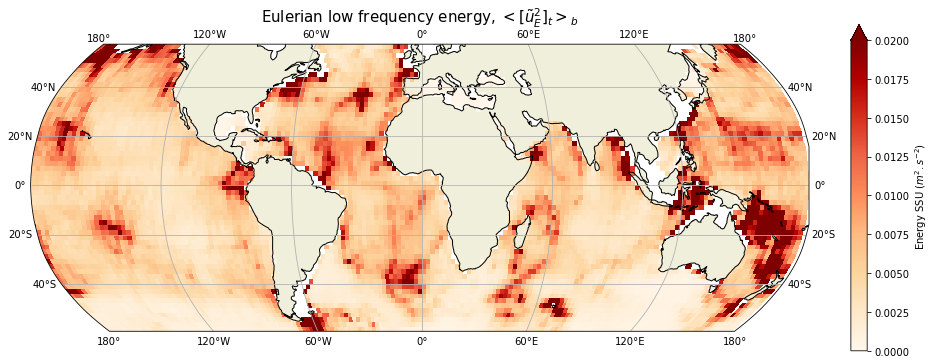

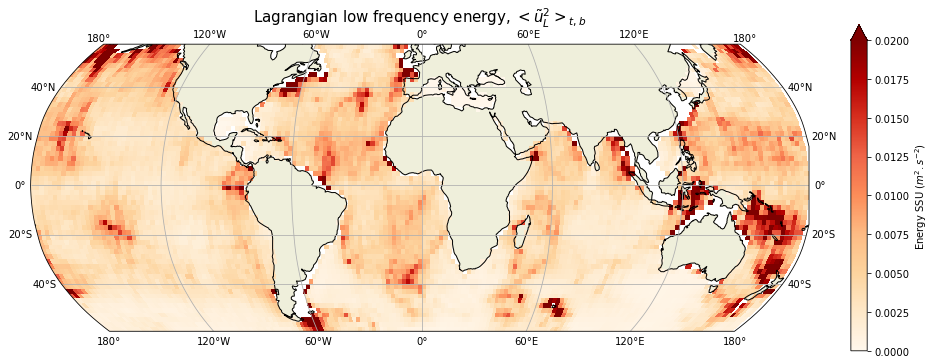

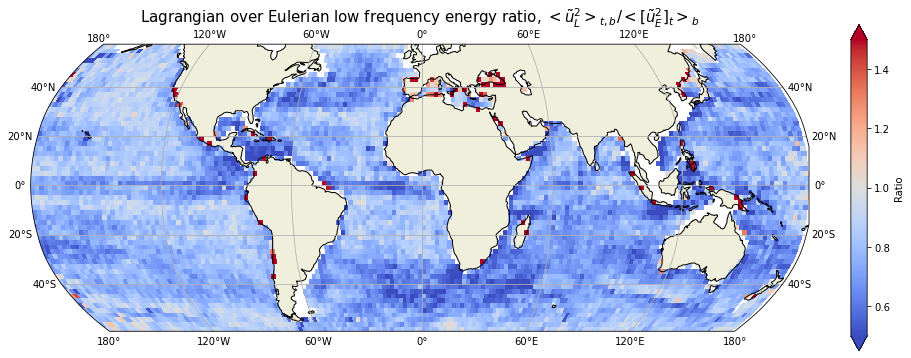

In [47]:
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_hf_dl2.E_energy_SSV,colmap=cmap,vlim=(0,0.02),**{'label':r'Energy SSU ($m^2.s^{-2}$)'})
ax.set_title(r'Eulerian low frequency energy, $<[\tilde u_E^2]_t>_b$',size=15)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_hf_dl2.L_energy_SSV,colmap=cmap,vlim=(0,0.02),**{'label':r'Energy SSU ($m^2.s^{-2}$)'})
ax.set_title(r'Lagrangian low frequency energy, $<\tilde u_L^2>_{t,b}$',size=15)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_hf_dl2.L_energy_SSV/ds_hf_dl2.E_energy_SSV,colmap='coolwarm',vlim=(0.5,1.5),**{'label':'Ratio'})
ax.set_title(r'Lagrangian over Eulerian low frequency energy ratio, $<\tilde u_L^2>_{t,b}/<[\tilde u_E^2]_t>_b$'
             ,size=15)

### Contamination

In [6]:
root_path = '/Users/zcaspar/codes/mit4320/'

#Eulerian
dsE_low_mean0 = xr.open_dataset(root_path+'E_low_fit_mean0_v2.nc')
dsE_low_mean1 = xr.open_dataset(root_path+'E_low_fit_mean1.nc')

#Lagrangian
dsL_low_mean0 = xr.open_dataset(root_path+'L_low_fit_mean0_v2.nc')
dsL_low_mean1 = xr.open_dataset(root_path+'L_low_fit_mean1.nc')

In [23]:
ds_low = xr.merge([xr.open_dataset(root_path+'energy_SSU_low_binned_dl2.0.nc'),
                   xr.open_dataset(root_path+'energy_SSV_low_binned_dl2.0.nc')])

k_pred = xr.open_dataset(root_path+'k_estimate.nc')

In [24]:
contamination = lambda ds : 4*ds['domega']/(np.pi*(ds['omega']**2)*ds['T'])

In [25]:
def get_tidal_frequencies(*args, units="cpd"):
    """
    """
    from pytide import WaveTable
    td = WaveTable()
    if units=="cpd":
        scale=86400/2/np.pi
    elif units=="cph":
        scale=3600/2/np.pi
    else:
        # cps
        scale=1/2/np.pi
    return {c: td.wave(c).freq * scale for c in args}

tidal_omega = get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2

In [32]:
Te = dsE_low_mean0.sel(param='T').parameters_SSU
Tev = dsE_low_mean0.sel(param='T').parameters_SSV

Tl = dsL_low_mean0.sel(param='T').parameters_SSU
Tlv = dsL_low_mean0.sel(param='T').parameters_SSV

Ue = ds_low.E_energy_SSU
Ve = ds_low.E_energy_SSV

Ul = ds_low.L_energy_SSU
Vl = ds_low.L_energy_SSV

domega = 0.2
_omega = omega

In [33]:
dsE_contamination = xr.Dataset({'omega':_omega,'domega':domega,'T':Te})
dsEV_contamination = xr.Dataset({'omega':_omega,'domega':domega,'T':Tev})

dsL_contamination = xr.Dataset({'omega':_omega,'domega':domega,'T':Tl})
dsLV_contamination = xr.Dataset({'omega':_omega,'domega':domega,'T':Tlv})

In [34]:
_dsL = contamination(dsL_contamination)
_dsLV = contamination(dsLV_contamination)

_dsE = contamination(dsE_contamination)
_dsEV = contamination(dsEV_contamination)

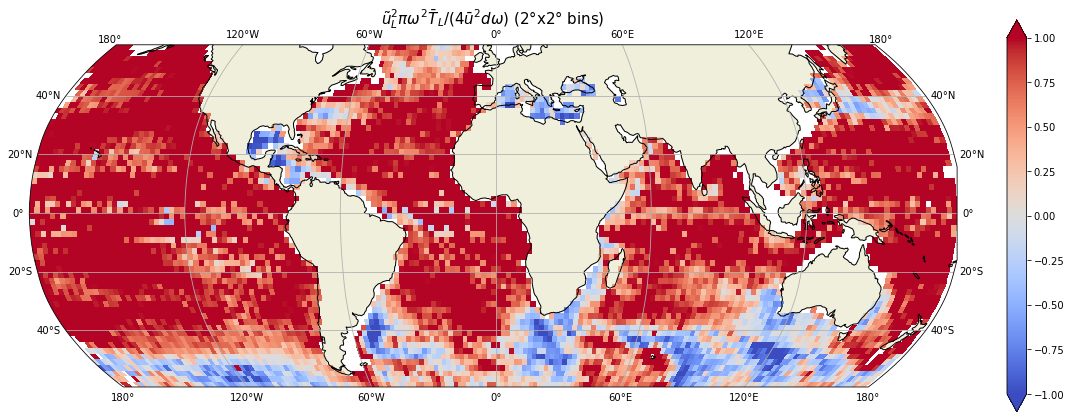

In [35]:
figsize=(15,6)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(ds_hf_dl2.L_energy_SSU/(_dsL*Ul)),vlim=(-1,1),colmap='coolwarm')
ax.set_title(r'$\tilde u_L^2\pi\omega^2\bar T_L/(4\bar u^2d\omega)$ (2°x2° bins)',size=15)
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_ratio_lf_contamination_SSU.png',bbox_inches='tight')

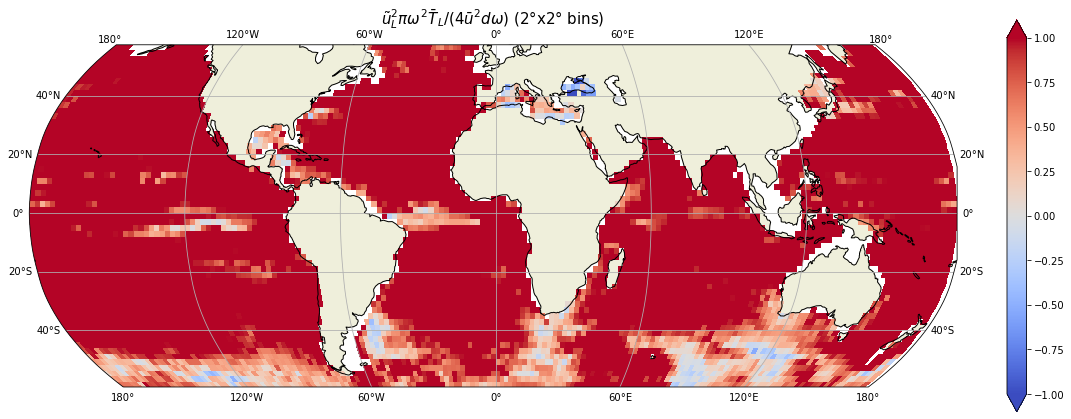

In [36]:
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(ds_hf_dl2.E_energy_SSU/(_dsE*Ue)),vlim=(-1,1),colmap='coolwarm')
ax.set_title(r'$\tilde u_L^2\pi\omega^2\bar T_L/(4\bar u^2d\omega)$ (2°x2° bins)',size=15)
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/E_ratio_lf_contamination_SSU.png',bbox_inches='tight')

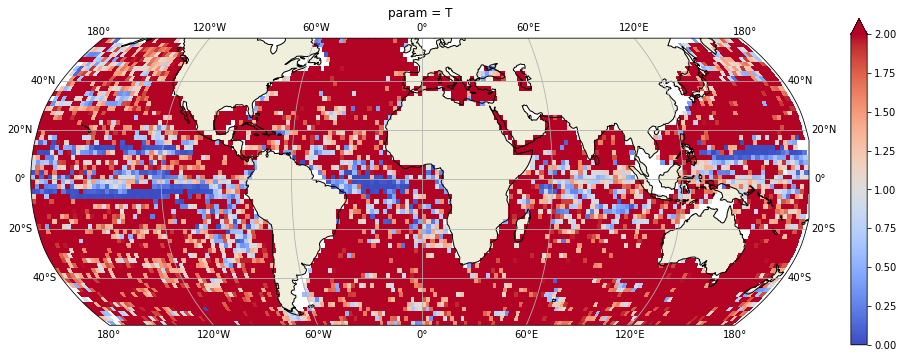

In [39]:
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(((_dsL*Ul)/(_dsE*Ue)),vlim=(0,2),colmap='coolwarm')

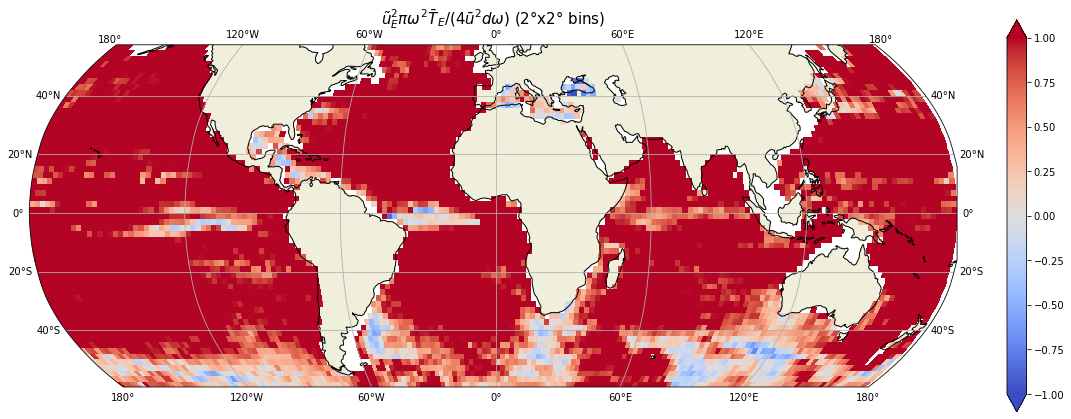

In [102]:
figsize=(15,6)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(ds_hf_dl2.L_energy_SSU/(_ds*U)),vlim=(-1,1),colmap='coolwarm')
ax.set_title(r'$\tilde u_E^2\pi\omega^2\bar T_E/(4\bar u^2d\omega)$ (2°x2° bins)',size=15)
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/E_ratio_lf_contamination_SSU.png',bbox_inches='tight')

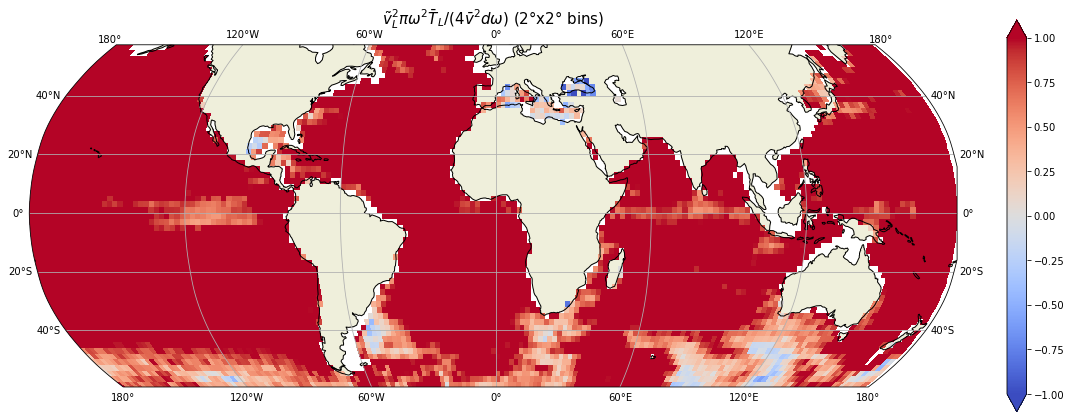

In [30]:
figsize=(15,6)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(ds_hf_dl2.E_energy_SSV/(_dsV*V)),vlim=(-1,1),colmap='coolwarm')
ax.set_title(r'$\tilde v_L^2\pi\omega^2\bar T_L/(4\bar v^2d\omega)$ (2°x2° bins)',size=15)
fig.tight_layout()

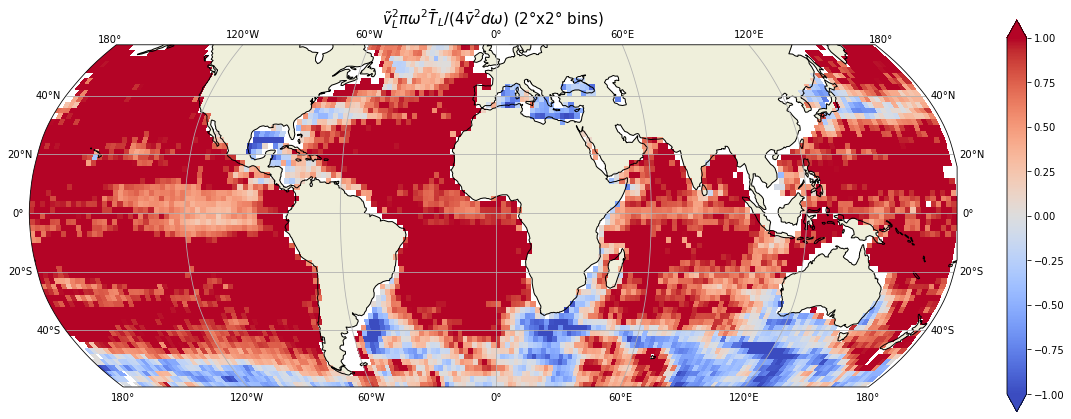

In [98]:
figsize=(15,6)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(ds_hf_dl2.L_energy_SSV/(_dsV*V)),vlim=(-1,1),colmap='coolwarm')
ax.set_title(r'$\tilde v_L^2\pi\omega^2\bar T_L/(4\bar v^2d\omega)$ (2°x2° bins)',size=15)
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/ratio_lf_contamination_SSV.png',bbox_inches='tight')

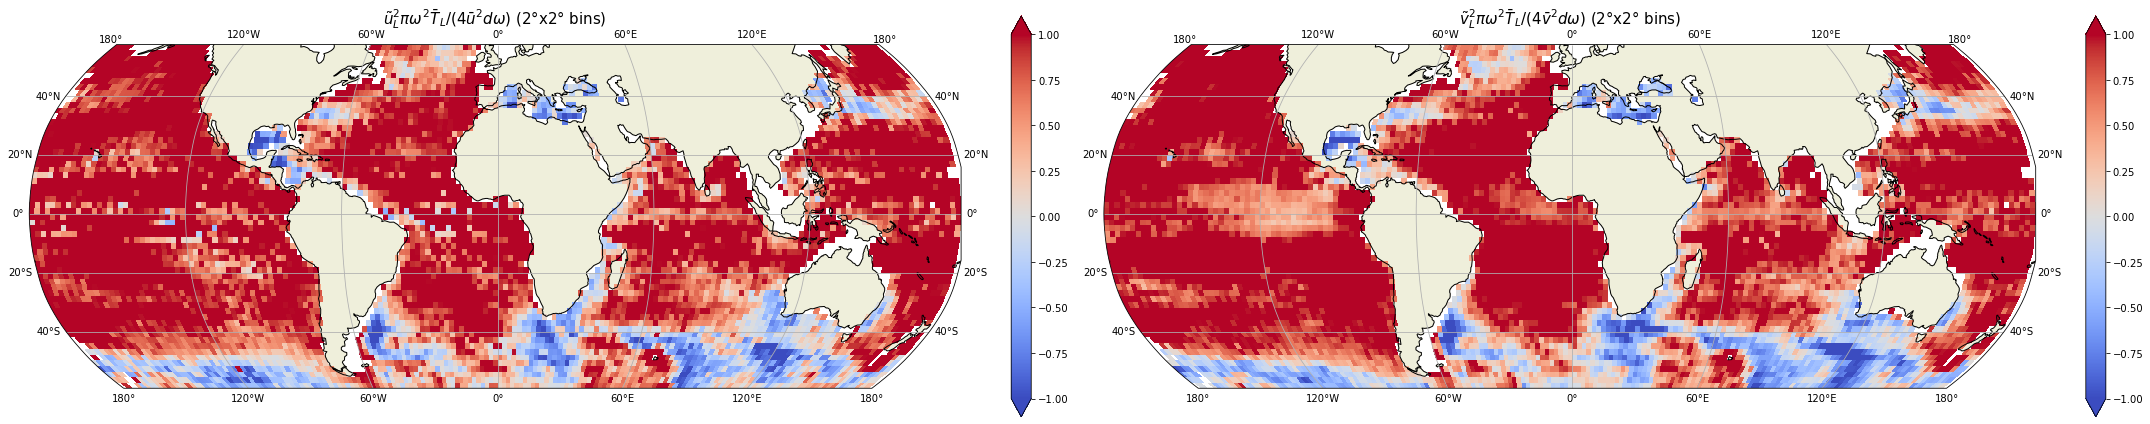

In [77]:
figsize = (30,6)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(ds_hf_dl2.L_energy_SSU/(_ds*U)),vlim=(-1,1),colmap='coolwarm',axes=121)
ax.set_title(r'$\tilde u_L^2\pi\omega^2\bar T_L/(4\bar u^2d\omega)$ (2°x2° bins)',size=15)

fig,ax = plot_maps(np.log10(ds_hf_dl2.L_energy_SSV/(_dsV*V)),vlim=(-1,1),colmap='coolwarm',axes=122)
ax.set_title(r'$\tilde v_L^2\pi\omega^2\bar T_L/(4\bar v^2d\omega)$ (2°x2° bins)',size=15)
#fig,ax = plot_maps(ds_hf_dl2.E_energy_SSU,colmap=cmap,vlim=(0,0.02),axes=122,**{'label':r'Energy SSU ($m^2.s^{-2}$)'})
#ax.set_title(r'Eulerian low frequency energy, $<[\tilde u_E^2]_t>_b$',size=15)
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_lf_contamination_mean0.png',bbox_inches='tight')

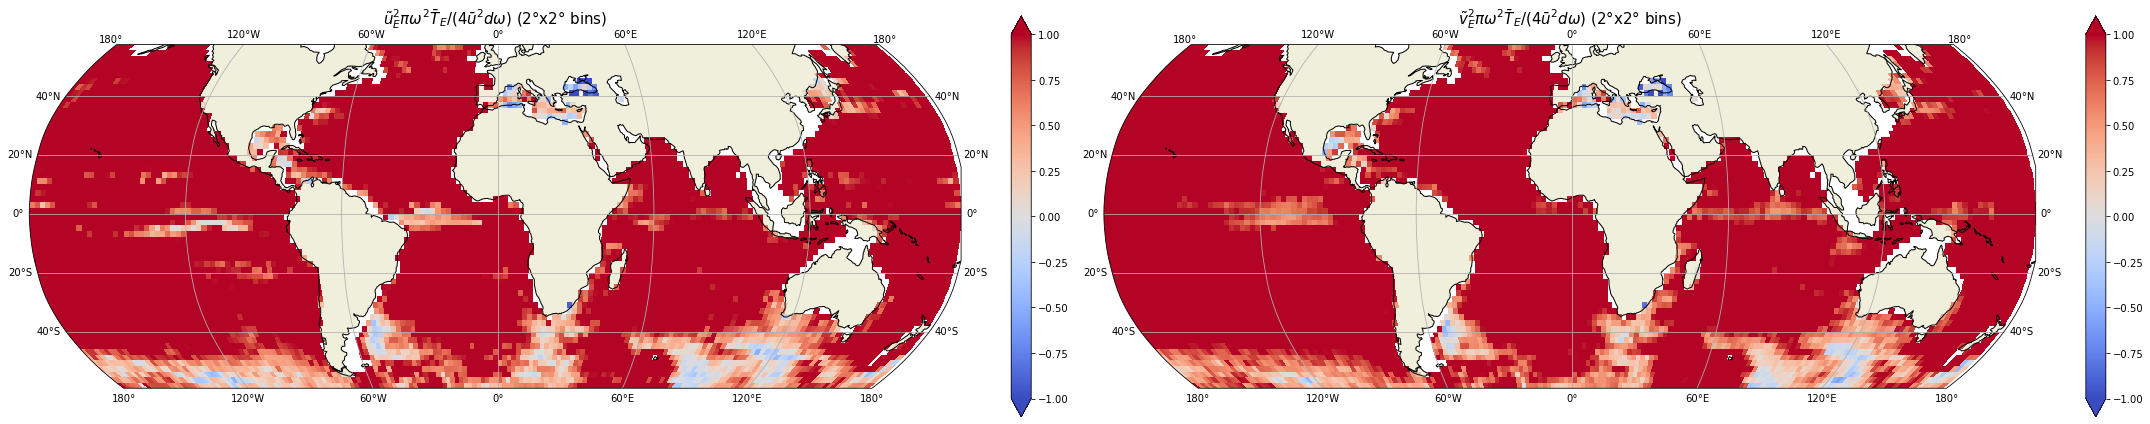

In [73]:
figsize = (30,6)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(ds_hf_dl2.E_energy_SSU/(_ds*U)),vlim=(-1,1),colmap='coolwarm',axes=121)
ax.set_title(r'$\tilde u_E^2\pi\omega^2\bar T_E/(4\bar u^2d\omega)$ (2°x2° bins)',size=15)

fig,ax = plot_maps(np.log10(ds_hf_dl2.E_energy_SSV/(_dsV*V)),vlim=(-1,1),colmap='coolwarm',axes=122)
ax.set_title(r'$\tilde v_E^2\pi\omega^2\bar T_E/(4\bar u^2d\omega)$ (2°x2° bins)',size=15)
#fig,ax = plot_maps(ds_hf_dl2.E_energy_SSU,colmap=cmap,vlim=(0,0.02),axes=122,**{'label':r'Energy SSU ($m^2.s^{-2}$)'})
#ax.set_title(r'Eulerian low frequency energy, $<[\tilde u_E^2]_t>_b$',size=15)
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/E_lf_contamination_mean0.png',bbox_inches='tight')

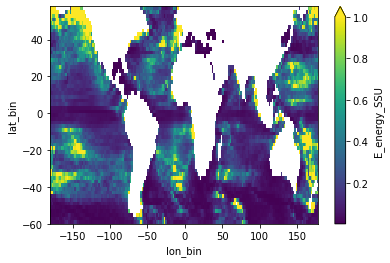

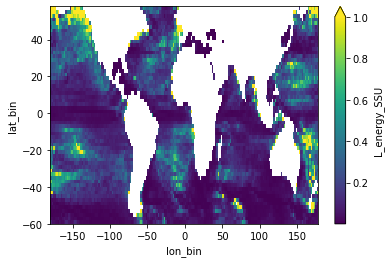

In [14]:
(ds_hf_dl2/ds_low).E_energy_SSU.plot(y='lat_bin',vmax=1)
plt.figure()
(ds_hf_dl2/ds_low).L_energy_SSU.plot(y='lat_bin',vmax=1)
#ds_low

### Sea level : 

In [15]:

dsE_Eta = xr.open_dataset(root_path+'Ecov_Eta_dl2.nc')



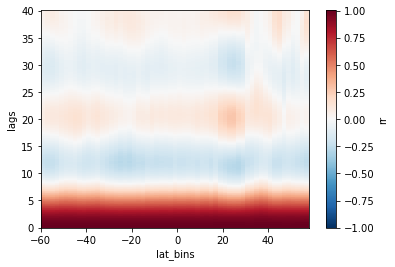

In [22]:
(dsE_Eta.mean(['lon_bins']).rr/dsE_Eta.mean(['lon_bins']).rr.isel(lags=0)).plot()